# Twitter Sentiment Analysis

This notebook aims to analyze Tweets made about the COVID-19 vaccine and determine whether the sentiment of the Tweets is negative, positive, or neutral.

## Libraries

In [12]:
import tweepy
import webbrowser
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import config
pd.set_option('display.max_colwidth', None)

from tweepy import OAuthHandler
from tweepy import API

import googletrans

## Gather data from Twitter API

In [2]:
# Developer API keys
# API keys in config.py in .gitignore
callback_uri = 'oob'

In [3]:
auth = OAuthHandler(config.consumer_key, config.consumer_secret, callback_uri)
auth.set_access_token(config.access_token, config.access_token_secret)

In [4]:
api = API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify= True)

In [5]:
# show my Twitter handle
me = api.me()
print(me.screen_name)

cassienutter1


In [ ]:
# simple query to get the hang of it
query = '#vaccine covid'
for i, status in enumerate(tweepy.Cursor(api.search, q= query).items(50)):
    print (i, status.text)

# filter only English tweets    
# query = '#vaccine covid'
# for i, status in enumerate(tweepy.Cursor(api.search, q= query, lang= 'en').items(50)):
#     print (i, status.text)

In [ ]:
''' This cell was run to collect the initial 5000 tweets and save them to a csv file
is commented out to prevent it from being run again


# collect 5000 tweets 
number_of_tweets = 5000
tweets = []
language = []
time = []

# only collect full text, language, and time it was posted
# remove any retweets '-RT'
for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                       tweet_mode = 'extended').items(number_of_tweets):
    tweets.append(i.full_text)
    language.append(i.lang)
    time.append(i.created_at)

# turn tweets / lists into dataframe
df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})

# save df to csv
df.to_csv('data/tweets.csv', index= False)
'''

Collect more tweets after waiting to avoid collecting the same tweets.

In [6]:
# create function to get more tweets and add to existing csv
def get_more_tweets(num_tweets):
    number_of_tweets = num_tweets
    tweets = []
    language = []
    time = []

    # only collect full text, language, and time it was posted
    # remove any retweets '-RT'
    for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                           tweet_mode = 'extended').items(number_of_tweets):
        tweets.append(i.full_text)
        language.append(i.lang)
        time.append(i.created_at)
        
    # turn tweets / lists into dataframe
    df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})
    
    # add to existing csv file
    df.to_csv('data/tweets.csv', mode= 'a', index= False, header= False)

In [7]:
get_more_tweets(50)

### Search for Tweets from 30 Days Ago

In [ ]:
# function to turn results into DataFrame
def extract_text_as_df(text_list):
    columns = set()
    allowed_types = [str, int]
    tweets_data = []
    for status in text_list:
        status_dict = dict(vars(status))
        keys = status_dict.keys()
        single_tweet_data = {"author": status.author.screen_name}
        for k in keys:
            try:
                v_type = type(status_dict[k])
            except:
                v_type = None
            if v_type != None:
                if v_type in allowed_types:
                    single_tweet_data[k] = status_dict[k]
                    columns.add(k)
        tweets_data.append(single_tweet_data)


    header_cols = list(columns)
    header_cols.append('author')
    df = pd.DataFrame(tweets_data, columns=header_cols)
    return df

In [ ]:
query = 'vaccine covid -RT'
results_30 = api.search_30_day('datacollection', query, maxResults= 100)

In [ ]:
old_results_df = extract_text_as_df(results_30)

In [ ]:
old_results_df

## Data Cleaning

In [9]:
df = pd.read_csv('data/tweets.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10350 entries, 0 to 10349
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      10350 non-null  object
 1   language  10350 non-null  object
 2   tweets    10350 non-null  object
dtypes: object(3)
memory usage: 242.7+ KB


In [13]:
# check for duplicated tweets
duped = df[df.duplicated(subset= 'tweets')]
duped

,time,language,tweets
812,2021-04-01 21:33:38,en,"⚠By scheduling your COVID-19 vaccine appointment you are confirming that you are eligible for a COVID-19 vaccine and that you are at least 16 years of age⚠️\nThis event is for anyone eligible in Phase 1A Tiers 1 &amp; 2, Phase 1B Tiers 1, 2, 3, and 4."
905,2021-04-01 21:30:59,en,"Having trouble getting an appointment for the COVID vaccine? If you're willing to drive to Salisbury, starting tomorrow any eligible Marylander will be able to get the shot without an appointment. @GovLarryHogan says they plan to add walk-up lines at other mass vaccination sites"
1281,2021-04-01 21:21:57,en,@annezinkmd Oops. \n\nI'm sure they caught any previous mix-ups...it's not like J&amp;J ever lied about product ingredients before....what's that? \n\nCancer causing asbestos in powder for decades? They knew all along? 4 Billion $ settlement? Oh. Welllll...\n\nhttps://t.co/CYUDPtLCn3
2502,2021-04-01 20:50:38,en,@GovParsonMO 57 we’ve no need to thank for\nhis vaccine distribution stank.\nLengthy drives he endorsed;\ncities underresourced. No state-\nwide mask mandate? Still his plank!\nPublic health Parson failed to police;\nCOVID cases he caused to increase.\n\n@COVIDOversight 👇🏼 @VP\nhttps://t.co/DPzYEbX1Es
2506,2021-04-01 20:50:27,en,@GovParsonMO 57 we’ve no need to thank for\nhis vaccine distribution stank.\nLengthy drives he endorsed;\ncities underresourced. No state-\nwide mask mandate? Still his plank!\nPublic health Parson failed to police;\nCOVID cases he caused to increase.\n\n@COVIDOversight 👇🏼 @VP\nhttps://t.co/DPzYEbX1Es
2515,2021-04-01 20:50:14,en,@GovParsonMO 57 we’ve no need to thank for\nhis vaccine distribution stank.\nLengthy drives he endorsed;\ncities underresourced. No state-\nwide mask mandate? Still his plank!\nPublic health Parson failed to police;\nCOVID cases he caused to increase.\n\n@COVIDOversight 👇🏼 @VP\nhttps://t.co/DPzYEbX1Es
2523,2021-04-01 20:50:05,en,@GovParsonMO 57 we’ve no need to thank for\nhis vaccine distribution stank.\nLengthy drives he endorsed;\ncities underresourced. No state-\nwide mask mandate? Still his plank!\nPublic health Parson failed to police;\nCOVID cases he caused to increase.\n\n@COVIDOversight 👇🏼 @VP\nhttps://t.co/DPzYEbX1Es
2535,2021-04-01 20:49:51,en,"hopefully getting discharged today! and starting therapy, new medicine and im getting a covid vaccine referral 💕"
3464,2021-04-01 20:26:27,en,Information about COVID-19 vaccine eligibility and availability can change quickly. Please always check with the health unit or the health organization before you try to book an appointment.
4455,2021-04-01 20:00:14,en,For more information on COVID-19 vaccine clinics please visit: https://t.co/hbF0NyDM5a


In [14]:
# remove duplicates
df.drop_duplicates(subset= 'tweets', keep= 'first', inplace= True)
df.reset_index(drop= True, inplace= True)

# make sure they are gone
df.tweets.duplicated().sum()

0

## EDA

### Looking at Languages

In [15]:
lang_df = df.sort_values('language')

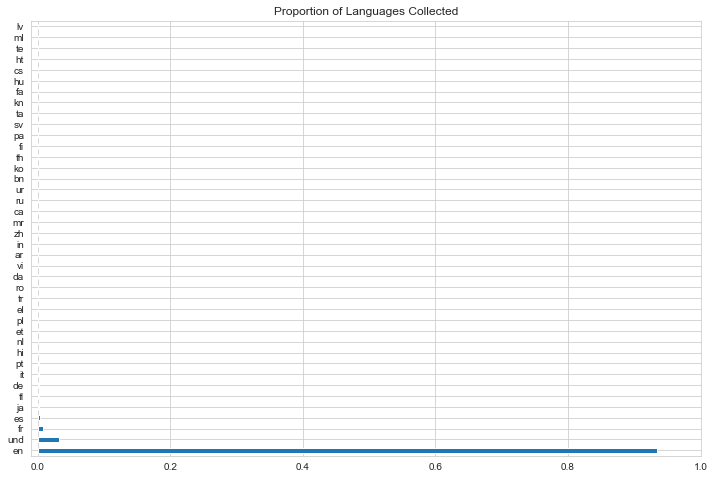

In [16]:
plt.figure(figsize= (12, 8))
lang_df.language.value_counts(normalize=True).plot(kind= 'barh')
plt.title('Proportion of Languages Collected')
plt.xlim(-.01, 1)
plt.show()

In [17]:
lang_df.language.value_counts(normalize=True)

en     0.934288
und    0.032614
fr     0.008516
es     0.004065
ja     0.002419
tl     0.001936
de     0.001548
it     0.001452
pt     0.001355
hi     0.001161
nl     0.001065
et     0.000968
pl     0.000871
el     0.000677
tr     0.000677
ro     0.000581
da     0.000484
vi     0.000484
ar     0.000387
in     0.000387
zh     0.000387
mr     0.000290
ca     0.000290
ru     0.000290
ur     0.000290
bn     0.000290
ko     0.000194
th     0.000194
fi     0.000194
pa     0.000194
sv     0.000194
ta     0.000194
kn     0.000194
fa     0.000194
hu     0.000194
cs     0.000097
ht     0.000097
te     0.000097
ml     0.000097
lv     0.000097
Name: language, dtype: float64

In [18]:
# what are these languages? get table from url
URL = 'https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages'
tables = pd.read_html(URL)
print("There are : ",len(tables)," tables")
print(tables[0])

lang_table = tables[0]

There are :  1  tables
                        0              1
0                    Name  Language code
1       English (default)             en
2                  Arabic             ar
3                 Bengali             bn
4                   Czech             cs
5                  Danish             da
6                  German             de
7                   Greek             el
8                 Spanish             es
9                 Persian             fa
10                Finnish             fi
11               Filipino            fil
12                 French             fr
13                 Hebrew             he
14                  Hindi             hi
15              Hungarian             hu
16             Indonesian             id
17                Italian             it
18               Japanese             ja
19                 Korean             ko
20                  Malay            msa
21                  Dutch             nl
22              Norwegian         

In [19]:
# format table
header_row = 0
lang_table.columns = lang_table.iloc[header_row]
lang_table = lang_table.drop(header_row)
lang_table.reset_index(drop= True, inplace= True)

lang_table.replace('English (default)', 'English', inplace= True)
# lang_table

,Name,Language code
0,English,en
1,Arabic,ar
2,Bengali,bn
3,Czech,cs
4,Danish,da
5,German,de
6,Greek,el
7,Spanish,es
8,Persian,fa
9,Finnish,fi


In [ ]:
# save as csv in data folder
lang_table.to_csv('data/languages.csv', index= False)

In [20]:
# look at 'und' language 
df[df['language'] == 'und']

,time,language,tweets
1,2021-04-01 21:58:44,und,@and_kell @ds13_manon https://t.co/sKnTctMKcF
19,2021-04-01 21:58:14,und,https://t.co/j2braq4wFx
29,2021-04-01 21:57:58,und,@Pavlos80322302 @ds13_manon https://t.co/sKnTctMKcF
79,2021-04-01 21:56:21,und,👍🏼👍🏼👍🏼👍🏼 https://t.co/m68KkEqpOe
97,2021-04-01 21:55:44,und,https://t.co/Stomi0I13k
...,...,...,...
10156,2021-04-02 12:34:01,und,@NaddiiaB @Flobga @Conseil_Etat https://t.co/ca6spF82qm
10184,2021-04-02 12:33:06,und,@annika1021 \n\nhttps://t.co/oN4rAXUfCc
10207,2021-04-02 12:32:21,und,https://t.co/6OsrUyOdNi
10268,2021-04-02 12:30:19,und,https://t.co/EJqUgZK6fI


It appears that the 'und' or possibly 'undetermined' language are tweets that only include links. We will remove those from our DataFrame.

In [21]:
df = df[df['language'] != 'und']
# df.info()

Merge the data with the languages to see the whole name of languages

In [22]:
# merge data with language names
df2 = df.merge(lang_table, how= 'inner', left_on= 'language', right_on= 'Language code')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9942 entries, 0 to 9941
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   time           9942 non-null   object
 1   language       9942 non-null   object
 2   tweets         9942 non-null   object
 3   Name           9942 non-null   object
 4   Language code  9942 non-null   object
dtypes: object(5)
memory usage: 466.0+ KB


In [23]:
# drop extra columns and rename them and change dates to datetime and drop time
df2.drop(columns = ['language', 'Language code'], inplace= True)
df2.rename(columns={'Name': 'language'}, inplace= True)
df2['time'] = pd.to_datetime(df2['time']).dt.date
# df2

,time,tweets,language
0,2021-04-01,"Concerning the use of aborted baby tissue in the J&amp;J Covid vaccine:\n\n“The J&amp;J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago.”\n\nEvil is still evil, even if it was decades ago.",English
1,2021-04-01,imagine an animal getting the covid-19 vaccine b4 a human,English
2,2021-04-01,Definition of a microstate: https://t.co/8N0R8Mhl73\n\nSource of vaccine data: https://t.co/0RQFJPTrZZ,English
3,2021-04-01,"If I’ve Had COVID-19, Do I Still Need Two Doses of Vaccine? https://t.co/08AiBgfEHQ",English
4,2021-04-01,"My epidural was delayed again, somehow my covid vaccine does not interact well with an epidural. SOOOOO I should be getting it on my birthday. Yay. \n\n So far I have 1-2 dr appointments a week this entire month.\n \nOn the upside they've given me proper muscle relaxers this time.",English
...,...,...,...
9937,2021-04-02,ایم ایس سیرل کمپنی لمیٹڈ کاچینی کمپنی لیوزون مافارم انکارپوریشن کے ساتھ ملک میں کورونا وائرس ویکسین (V-01) کی تیاری کا معاہدہ ہو گیا\nhttps://t.co/6M4DwiC5Fn,Urdu
9938,2021-04-02,سیاسی رہنما ڈاکٹر فاروق ستار نے کورونا ویکسین لگوا لی\n\nسیاسی رہنما ڈاکٹر فاروق ستار نے بھی کورونا ویکسین لگوا لی۔ ڈاکٹر فاروق ستار نے ایم ایس سروسز اسپتال کراچی میں قائم ویکسین سینٹر کا دورہ کیا اور کورونا سے بچاؤ کی ویکسین لگوائی۔\n\nویکسین لگوانے کے ب… https://t.co/iI7vlEOyBJ https://t.co/HQ50p7BuDz,Urdu
9939,2021-04-02,টিকা নিলেও নিতে হবে সাবধানতা।\n#coronavirus #CoronavirusVaccine #UttarPradesh \n\nhttps://t.co/nHoUZKkSRV,Bengali
9940,2021-04-02,"সপরিবার কোভিড টিকা নিলেন অমিতাভ, বাকি শুধু অভিষেক \n@SrBachchan \n\nhttps://t.co/JdietMQ2xU",Bengali


Let's see how many Tweets are in each language?

<AxesSubplot:xlabel='count', ylabel='language'>

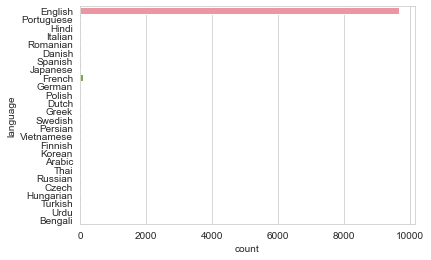

In [24]:
sns.countplot(y= 'language', data= df2)

The majority of Tweets are in English. Let's see what the other languages are.

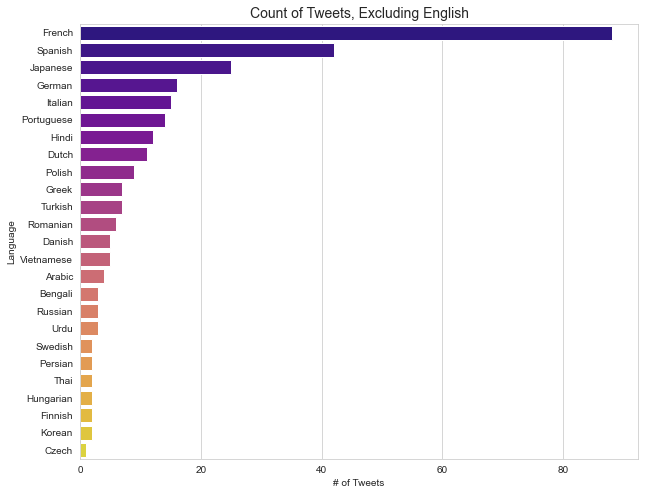

In [29]:
# countplot that excludes English to see detail
plt.figure(figsize= (10, 8))
sns.countplot(y= 'language', data= df2, palette='plasma',
              order= df2.language.value_counts().iloc[1:].index)
plt.title('Count of Tweets, Excluding English', fontsize= 14)
plt.xlabel('# of Tweets')
plt.ylabel('Language')
plt.show()

After English, the top 3 languages for Tweets about the COVID-19 vaccine are in French, Spanish, and Japanese.

In [ ]:
##translate all to english?
# googletrans?

## Text Sentiment
---
Does the tweet have a positive, negative, or neutral tone?

### Feature Engineering for Text Data
--- 
stopword removal
frequency distributions
lemmatization
bigramsm n-grams, and mutal information score

In [ ]:
# convert text to lowercase

In [ ]:
# remove punctuation

In [ ]:
# tokenization

In [ ]:
# stop words removal

In [ ]:
# lemmatization

In [ ]:
# Part of speech (POS) tagging